In [1]:
from __future__ import print_function
import os
import sys
import time
import numpy as np
import re
import faiss
import inspect
from multiprocessing.dummy import Pool as ThreadPool
from matplotlib import pyplot

save_data = False

In [2]:
inspect.getmembers(faiss)

[('ArrayInvertedLists', faiss.swigfaiss_avx2.ArrayInvertedLists),
 ('ArrayInvertedLists_swigregister',
  <function faiss._swigfaiss_avx2.ArrayInvertedLists_swigregister>),
 ('AutoTuneCriterion', faiss.swigfaiss_avx2.AutoTuneCriterion),
 ('AutoTuneCriterion_swigregister',
  <function faiss._swigfaiss_avx2.AutoTuneCriterion_swigregister>),
 ('BitstringReader', faiss.swigfaiss_avx2.BitstringReader),
 ('BitstringReader_swigregister',
  <function faiss._swigfaiss_avx2.BitstringReader_swigregister>),
 ('BitstringWriter', faiss.swigfaiss_avx2.BitstringWriter),
 ('BitstringWriter_swigregister',
  <function faiss._swigfaiss_avx2.BitstringWriter_swigregister>),
 ('BufferList', faiss.swigfaiss_avx2.BufferList),
 ('BufferList_swigregister',
  <function faiss._swigfaiss_avx2.BufferList_swigregister>),
 ('BufferedIOReader', faiss.swigfaiss_avx2.BufferedIOReader),
 ('BufferedIOReader_swigregister',
  <function faiss._swigfaiss_avx2.BufferedIOReader_swigregister>),
 ('BufferedIOWriter', faiss.swigfais

In [3]:
def mmap_fvecs(fname):
    x = np.memmap(fname, dtype='int32', mode='r')
    d = x[0]
    return x.view('float32').reshape(-1, d + 1)[:, 1:]


def mmap_bvecs(fname):
    x = np.memmap(fname, dtype='uint8', mode='r')
    d = x[:4].view('int32')[0]
    return x.reshape(-1, d + 4)[:, 4:]

def ivecs_read(fname):
    a = np.fromfile(fname, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy()

dbname        = 'SIFT100M'
index_key     = 'OPQ16,IVF8192,PQ16'
parametersets = ['nprobe=1', 'nprobe=32']


tmpdir = '../trained_CPU_indexes/bench_cpu_{}_{}'.format(dbname, index_key)

if not os.path.isdir(tmpdir):
    raise("%s does not exist")


#################################################################
# Prepare dataset
#################################################################


print("Preparing dataset", dbname)

if dbname.startswith('SIFT'):
    # SIFT1M to SIFT1000M
    dbsize = int(dbname[4:-1])
    xb = mmap_bvecs('../bigann/bigann_base.bvecs')
    xq = mmap_bvecs('../bigann/bigann_query.bvecs')
    xt = mmap_bvecs('../bigann/bigann_learn.bvecs')

    # trim xb to correct size
    xb = xb[:dbsize * 1000 * 1000]

    gt = ivecs_read('../bigann/gnd/idx_%dM.ivecs' % dbsize)

elif dbname == 'Deep1B':
    xb = mmap_fvecs('../deep1b/base.fvecs')
    xq = mmap_fvecs('../deep1b/deep1B_queries.fvecs')
    xt = mmap_fvecs('../deep1b/learn.fvecs')
    # deep1B's train is is outrageously big
    xt = xt[:10 * 1000 * 1000]
    gt = ivecs_read('../deep1b/deep1B_groundtruth.ivecs')

else:
    print('unknown dataset', dbname, file=sys.stderr)
    sys.exit(1)


print("sizes: B %s Q %s T %s gt %s" % (
    xb.shape, xq.shape, xt.shape, gt.shape))

nq, d = xq.shape
nb, d = xb.shape
assert gt.shape[0] == nq


#################################################################
# Load Index
#################################################################

def get_populated_index():

    filename = "%s/%s_%s_populated.index" % (
        tmpdir, dbname, index_key)

    if not os.path.exists(filename):
        raise("Index does not exist!")
    else:
        print("loading", filename)
        index = faiss.read_index(filename)
    return index


Preparing dataset SIFT100M
sizes: B (100000000, 128) Q (10000, 128) T (100000000, 128) gt (10000, 1000)


In [4]:
#################################################################
# Perform searches
#################################################################

index = get_populated_index()

ps = faiss.ParameterSpace()
ps.initialize(index)

# make sure queries are in RAM
xq = xq.astype('float32').copy()

# a static C++ object that collects statistics about searches
ivfpq_stats = faiss.cvar.indexIVFPQ_stats
ivf_stats = faiss.cvar.indexIVF_stats


# we do queries in a single thread
faiss.omp_set_num_threads(1)

print(' ' * len(parametersets[0]), '\t', 'R@1    R@10   R@100     time    %pass')

for param in parametersets:
    print(param, '\t', end=' ')
    sys.stdout.flush()
    ps.set_index_parameters(index, param)
    t0 = time.time()
    ivfpq_stats.reset()
    ivf_stats.reset()
    faiss_result_dist, faiss_result_idx = index.search(xq, 100)
    t1 = time.time()
    for rank in 1, 10, 100:
        n_ok = (faiss_result_idx[:, :rank] == gt[:, :1]).sum()
        print("%.4f" % (n_ok / float(nq)), end=' ')
    print("%8.3f  " % ((t1 - t0) * 1000.0 / nq), end=' ')
    print("%5.2f" % (ivfpq_stats.n_hamming_pass * 100.0 / ivf_stats.ndis))

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_OPQ16,IVF8192,PQ16/SIFT100M_OPQ16,IVF8192,PQ16_populated.index
         	 R@1    R@10   R@100     time    %pass
nprobe=1 	 0.2049 0.3759 0.3989    0.290    0.00
nprobe=32 	 0.3509 0.8287 0.9645    4.401    0.00


In [5]:
print("==== Distance ====\n\n{}\nshape: {}\n".format(faiss_result_idx, faiss_result_idx.shape))
print("==== Index ====\n\n{}\nshape: {}\n".format(faiss_result_dist, faiss_result_dist.shape))

==== Distance ====

[[28539420 45707400 46773680 ... 55265915 13938054 82025830]
 [23668085 42617250 75421544 ... 18049947 29432238 38626210]
 [39485386 79843555 68416783 ... 20524843 42248105 39892541]
 ...
 [27886876 50719824  9286338 ... 60885604 61139856 60885183]
 [44588513 49670008 33507495 ... 89735468 85891034 22924707]
 [23496503  7204070 22993981 ... 76869070 93745422  2491342]]
shape: (10000, 100)

==== Index ====

[[59443.13  59859.68  60580.996 ... 71293.51  71305.19  71322.98 ]
 [26953.395 32228.09  32741.707 ... 46338.6   46368.88  46529.29 ]
 [33986.766 37018.36  38662.93  ... 47866.91  47896.312 47996.367]
 ...
 [50020.715 51861.652 53017.348 ... 64580.1   64623.285 64664.734]
 [46331.938 47612.707 47689.535 ... 61916.67  61923.46  62037.934]
 [43953.285 45441.836 45818.02  ... 58331.895 58354.586 58364.47 ]]
shape: (10000, 100)



In [6]:
print("Query vector example\nxq\ttype: {}\tshape: {}\n".format(type(xq), xq.shape))
print(xq[0], xq[0].shape) 
# Why like integers? -> The sift1b dataset actually stores vector in uint8 format, to save space
#   size = 132000000000 bytes = (128 bytes vector + 4 bytes index) * 1B
print(xq[0][0])

Query vector example
xq	type: <class 'numpy.memmap'>	shape: (10000, 128)

[  3.   9.  17.  78.  83.  15.  10.   8. 101. 109.  21.   8.   3.   2.
   9.  64.  39.  31.  18.  80.  55.  10.   2.  12.   7.   7.  26.  58.
  32.   6.   4.   3.  14.   2.  13.  28.  37.  19.  47.  59. 109.  22.
   2.   6.  18.  15.  20. 109.  30.   8.  11.  44. 109.  54.  19.  32.
  17.  21.  15.  22.  12.  28. 101.  35.  66.  11.   9.  30.  68.  35.
  30.  75. 106. 103.  26.  50.  76.  20.   8.  13.  51.  41.  63. 109.
  40.   2.   3.  15.  36.  49.  21.  13.  12.   9.  36.  37.  52.  37.
  24.  34.  19.   3.  13.  23.  21.   8.   3.  20.  68.  56.  79.  60.
  99.  36.   7.  28.  78.  41.   7.  21.  74.  26.   3.  15.  34.  15.
  12.  27.] (128,)
3.0


In [7]:
def print_object_fields(obj):
    """ list values all fields of an object known to SWIG """

    for name in obj.__class__.__swig_getmethods__:
        print(f"{name} = {getattr(obj, name)}")

In [8]:
print_object_fields(index)

d = 128
ntotal = 100000000
verbose = False
is_trained = True
metric_type = 1
metric_arg = 0.0
chain = <faiss.swigfaiss_avx2.VectorTransformVector; proxy of <Swig Object of type 'std::vector< faiss::VectorTransform * > *' at 0x7f8d08e51b40> >
index = <faiss.swigfaiss_avx2.Index; proxy of <Swig Object of type 'faiss::Index *' at 0x7f8d08e51b40> >
own_fields = True


In [9]:
print_object_fields(index.index)

d = 128
ntotal = 100000000
verbose = False
is_trained = True
metric_type = 1
metric_arg = 0.0


In [10]:
""" Get OPQ Matrix """
linear_trans = faiss.downcast_VectorTransform(index.chain.at(0))
OPQ_mat = faiss.vector_to_array(linear_trans.A)
OPQ_mat = OPQ_mat.reshape((128,128))
OPQ_mat = np.array(OPQ_mat, dtype=np.float32)
print(OPQ_mat, OPQ_mat.shape)

[[-0.04185106  0.03428996  0.01463496 ...  0.26744068  0.08420503
  -0.12249091]
 [ 0.03530787  0.08281487 -0.05807371 ... -0.08664993 -0.05088573
  -0.24373505]
 [ 0.04926687  0.01517367 -0.00573028 ...  0.00100601  0.03905569
  -0.13516347]
 ...
 [ 0.10964511  0.08982475 -0.02009742 ... -0.0578454  -0.0549995
   0.04094499]
 [-0.12942526  0.17826557 -0.02329139 ... -0.0937097  -0.03088556
   0.12256143]
 [-0.1314367   0.14714412  0.01808932 ...  0.02709483 -0.03784304
  -0.10600516]] (128, 128)


In [11]:
""" Get IVF index (coarse quantizer) and product quantizer"""

downcasted_index = faiss.downcast_index(index.index)

def get_sub_quantizer_centroids(index):
    """
    return the sub-quantizer centroids, 
    shape = (m, 256, d / m)
    e.g., d=128, m=16 -> (16, 256, 8)
    """
    pq = index.pq
    cen = faiss.vector_to_array(pq.centroids)
    cen = cen.reshape(pq.M, pq.ksub, pq.dsub)
    
    return cen

def get_coarse_quantizer_centroids(index):
    """
    return the coarse-grained quantizer centroids,
    shape = (nlist, d),
    e.g., nlist=1024, d=128 -> (1024, 128)
    """
    coarse_quantizer = faiss.downcast_index(index.quantizer)
    coarse_cen = faiss.vector_to_array(coarse_quantizer.xb)

    coarse_cen = coarse_cen.reshape(coarse_quantizer.ntotal, coarse_quantizer.d)
    return coarse_cen

# Get Sub quantizer info
sub_cen = get_sub_quantizer_centroids(downcasted_index)
print("==== Sub-quantizer ====\n{}\n\nshape:{}\n".format(sub_cen, sub_cen.shape))

# Get Coarse quantizer info
coarse_cen = get_coarse_quantizer_centroids(downcasted_index)
print("==== Coarse-quantizer ====\n{}\n\nshape:{}\n".format(coarse_cen, coarse_cen.shape))

==== Sub-quantizer ====
[[[-30.197075   -23.236074   -13.366585   ... -11.393365     5.8771296
   -18.89725   ]
  [-33.022923   -15.39339      9.522758   ...  -8.383547    16.251562
    12.538808  ]
  [-14.867078    -2.4835837   -1.7066059  ...   3.1077738   19.915678
   -16.846704  ]
  ...
  [ 29.21712     13.204249     2.3176963  ...  16.067656   -24.286322
    30.081974  ]
  [ 28.375912    13.999012   -11.073188   ...  -4.282479   -21.07674
     6.6677904 ]
  [ 28.037931    42.105015     1.0285904  ...  35.699448    13.697935
   -14.478575  ]]

 [[ 20.051786    -8.370474     0.5161412  ...  12.963359   -15.200961
    27.656296  ]
  [ 15.461749   -10.884682     5.703733   ... -14.309333   -28.87946
     9.411468  ]
  [  6.2166452   -9.853486    16.709171   ...   9.081562   -18.439915
     7.429808  ]
  ...
  [-28.226736    26.75037    -23.633837   ...  -0.46722895  56.466084
   -13.462248  ]
  [-16.889128    30.844292    -5.331582   ...  17.001925    35.040524
   -19.33138   ]
  [-21

In [12]:
""" Transform input vectors """
assert xq.shape[0] == 10000 and xq.shape[1] == 128

xq_transformed = np.zeros((10000,128), dtype=np.float32)

for n in range(10000):
    for d in range(128): 
        # a row of input vector inner product a row of OPQ matrix
        xq_transformed[n,d] = np.inner(xq[n], OPQ_mat[d])
        
print(xq_transformed.shape)

(10000, 128)


In [13]:
""" Get contents in a single Voronoi Cell """
invlists = downcasted_index.invlists

def get_invlist(invlists, l):
    """ 
    returns the (vector IDs set, PQ cose set) of list ID "l"
    list_ids: (#vec_in_list, ), e.g., #vec_in_list=10 -> (10, )
    list_codes: (#vec_in_list, m), e.g., #vec_in_list=10, m=16 -> (10, 16)
    
    That the data is *NOT* copied: if the inverted index is deallocated or changes, accessing the array may crash.
    To avoid this, just clone the output arrays on output. 
    """
    ls = invlists.list_size(l)
    list_vec_ids = faiss.rev_swig_ptr(invlists.get_ids(l), ls)
    list_PQ_codes = faiss.rev_swig_ptr(invlists.get_codes(l), ls * invlists.code_size)
    list_PQ_codes = list_PQ_codes.reshape(-1, invlists.code_size)
    return list_vec_ids, list_PQ_codes


In [14]:
# Example of using function "get_invlist"
list_id = 123
list_vec_ids, list_PQ_codes = get_invlist(invlists, list_id)
print("==== Vector IDs ====\n{}\n\nshape: {}\n".format(list_vec_ids, list_vec_ids.shape))
print("==== PQ codes ====\n{}\n\nshape: {}\n".format(list_PQ_codes, list_PQ_codes.shape))

==== Vector IDs ====
[    7322     8476     9861 ... 99992803 99993000 99998092]

shape: (22469,)

==== PQ codes ====
[[ 35 194 255 ...  87  90 174]
 [162 208  42 ...  66 146 239]
 [155 136 127 ... 170 216  62]
 ...
 [ 35 136 177 ...  91  25  42]
 [  3   3 173 ... 102  82  70]
 [ 71 135  12 ... 113  92  78]]

shape: (22469, 16)



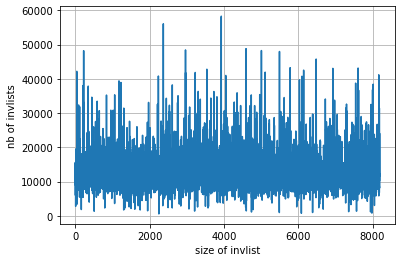

In [15]:
""" Distribution of number of vectors in each Voronoi Cell """
bc = [invlists.list_size(l) for l in range(invlists.nlist)]
pyplot.step(np.arange(len(bc)), bc)
pyplot.xlabel('size of invlist')
pyplot.ylabel('nb of invlists')
pyplot.grid()

In [16]:
"""
Self-implemented functions to search a query vectors
"""

def distance_full_vec(v1, v2):
    """Given 2 full vector, return their L2 distance"""
    assert len(v1) == len(v2)
    v_diff = v1 - v2
    dist = np.sum(v_diff * v_diff)
    return dist

def construct_distance_table(q_res, sub_cen):
    """
    q_res: a full precision query vector, shape = (d, ), e.g., (128, )
    sub_cen: sub-quantizer center, shape = (m, 256, d / m), e.g., d=128, m=16 -> (16, 256, 8)
    """
    M, ksub, dsub = sub_cen.shape
    dist_table = np.zeros(shape=(M, ksub))
    
    for m in range(M):
        q_res_part = q_res[m * dsub: (m + 1) * dsub]
        for k in range(ksub):
            PQ_cent = sub_cen[m][k]
            res_dist = PQ_cent - q_res_part
            dist = np.sum(res_dist * res_dist)
            
            dist_table[m, k] = dist
            
    return dist_table

def estimate_distance(pq_code, dist_table):
    """
    given single PQ code and its distance table, compute the estimated distance
    """
    # pq_cen -> (pq.M 8, pq.ksub 256, pq.dsub D/M=64/8=8)
    M = dist_table.shape[0]
    assert M == len(pq_code)
    
    dist = 0
    for m in range(M):
        dist += dist_table[m][pq_code[m]]
        
    return dist

def estimate_distances(vec_ids, pq_codes, dist_table):
    """
    A wrapper of "estimate_distance", estimating the distance of a batch
      of PQ codes
    vec_ids, pq_codes: get_invlist(invlists, closest_cell)
    center_dist: the distance from query vector to the coarse-grained
      cluster centroid.
      
    Return: an sorted list of pair (vec_id, distance)
       [(vec0, dist0), ... (vecN, distN)]
    """
    assert len(vec_ids) == len(pq_codes)
    vec_dist_list = []
    
    for i in range(len(vec_ids)):
        pq_code = pq_codes[i]
        vec_id = vec_ids[i]
        dist = estimate_distance(pq_code, dist_table)# + center_dist
        vec_dist_list.append((vec_id, dist))
        
    vec_dist_list.sort(key=lambda x:x[1])
    
    return vec_dist_list

def search_single_query(q_vec, nprobe, topk, coarse_cen, sub_cen):
    """
    Search a single query vector, shape = (d, )
    """
    
    # Compute the closest centroids
    coarse_dist_ls = []
    for i, c in enumerate(coarse_cen):
        dist = distance_full_vec(q_vec, c)
        coarse_dist_ls.append((dist, i)) # (distance, cell_id)
        
    coarse_dist_ls.sort(key=lambda x: x[0])

    # Estimate distance by ADC
    closest_cell_list = coarse_dist_ls[:nprobe]
    vec_dist_id_list = []
    for cell in closest_cell_list:
        cell_id = cell[1]
        center_dist = cell[0]
        list_ids, list_codes = get_invlist(invlists, cell_id)
        q_res = q_vec - coarse_cen[cell_id]
        # Note! store sub-quantizer once, but the number of compute = nprobe 
        dist_table = construct_distance_table(q_res, sub_cen)
        vec_dist_id_list_single_cell = estimate_distances(list_ids, list_codes, dist_table)
        vec_dist_id_list += vec_dist_id_list_single_cell
        
    vec_dist_id_list.sort(key=lambda x:x[1])
    vec_dist_id_list = vec_dist_id_list[:topk]
    id_list = [pair[0] for pair in vec_dist_id_list]
    dist_list = [pair[1] for pair in vec_dist_id_list]
    
    return id_list, dist_list

def search_batch_query(q_vecs, nprobe, topk, coarse_cen, sub_cen):
    """
    The wrapper of "search_single_query", search a batch of vectors
    input: q_vecs shape -> (batch_size, d)
    """
    id_list_batch = []
    dist_list_batch = []
    for q_vec in q_vecs:
        id_list, dist_list = search_single_query(q_vec, nprobe, topk, coarse_cen, sub_cen)
        id_list_batch.append(id_list)
        dist_list_batch.append(dist_list)
        
    return id_list_batch, dist_list_batch

In [17]:
""" Test single query """

nprobe = 32
topk = 100

### Faiss query shape: (10000, 128)

id_list, dist_list = search_single_query(xq_transformed[0], nprobe, topk, coarse_cen, sub_cen)
print("==== Vector IDs ====\n\n{}\n".format(id_list))
print("==== Distances ====\n\n{}\n".format(dist_list))

==== Vector IDs ====

[28539420, 45707400, 46773680, 86005936, 60148561, 99117874, 13934280, 504814, 14925721, 96288515, 68077216, 94162443, 40642738, 55581303, 78532328, 48483135, 1167285, 12218968, 66150808, 87356234, 46743061, 69278657, 64958776, 60066306, 71522777, 7251016, 18760679, 21686232, 77426987, 42364843, 42893280, 53179241, 91012149, 80468296, 31619937, 11615271, 53657183, 33431212, 13939580, 32715626, 97633081, 96140089, 91190119, 49801017, 86277858, 74111642, 48260397, 96502988, 93125274, 66402647, 60526618, 31619649, 43698823, 79311056, 31619607, 82774411, 12605138, 48080771, 80468484, 84156128, 17055412, 65697961, 69120560, 31620142, 26752722, 31619629, 13939528, 94896798, 70260430, 61457390, 80468463, 78763715, 94161292, 88762980, 21192937, 98350698, 33365690, 28798102, 13939195, 40156538, 14217376, 29057665, 76565525, 38421496, 53593682, 29057607, 62376144, 79146679, 9596430, 7293964, 61160735, 55935178, 18778717, 31619238, 67335636, 96419706, 43317471, 55265915, 139

In [18]:
print("ID Correct? ", np.allclose(id_list, faiss_result_idx[0]))
print("Distance Correct? ", np.allclose(dist_list, faiss_result_dist[0]))

ID Correct?  True
Distance Correct?  True


In [20]:
"""Batch Version"""
batch_size = 32

id_list, dist_list = search_batch_query(xq_transformed[:batch_size], nprobe, topk, coarse_cen, sub_cen)
print("==== Vector IDs ====\n\n{}\n".format(id_list))
print("==== Distances ====\n\n{}\n".format(dist_list))

==== Vector IDs ====

[[28539420, 45707400, 46773680, 86005936, 60148561, 99117874, 13934280, 504814, 14925721, 96288515, 68077216, 94162443, 40642738, 55581303, 78532328, 48483135, 1167285, 12218968, 66150808, 87356234, 46743061, 69278657, 64958776, 60066306, 71522777, 7251016, 18760679, 21686232, 77426987, 42364843, 42893280, 53179241, 91012149, 80468296, 31619937, 11615271, 53657183, 33431212, 13939580, 32715626, 97633081, 96140089, 91190119, 49801017, 86277858, 74111642, 48260397, 96502988, 93125274, 66402647, 60526618, 31619649, 43698823, 79311056, 31619607, 82774411, 12605138, 48080771, 80468484, 84156128, 17055412, 65697961, 69120560, 31620142, 26752722, 31619629, 13939528, 94896798, 70260430, 61457390, 80468463, 78763715, 94161292, 88762980, 21192937, 98350698, 33365690, 28798102, 13939195, 40156538, 14217376, 29057665, 76565525, 38421496, 53593682, 29057607, 62376144, 79146679, 9596430, 7293964, 61160735, 55935178, 18778717, 31619238, 67335636, 96419706, 43317471, 55265915, 13

In [22]:
for i in range(batch_size):
    print("i = {}\tID Correct? {}".format(i, np.allclose(id_list[i], faiss_result_idx[i], rtol=1e-02, atol=10)))
          
print("ID Correct? ", np.allclose(id_list, faiss_result_idx[:batch_size], rtol=1e-02, atol=10))
print("Distance Correct? ", np.allclose(dist_list, faiss_result_dist[:batch_size]))

i = 0	ID Correct? True
i = 1	ID Correct? True
i = 2	ID Correct? True
i = 3	ID Correct? True
i = 4	ID Correct? True
i = 5	ID Correct? True
i = 6	ID Correct? True
i = 7	ID Correct? False
i = 8	ID Correct? True
i = 9	ID Correct? True
i = 10	ID Correct? True
i = 11	ID Correct? True
i = 12	ID Correct? True
i = 13	ID Correct? True
i = 14	ID Correct? True
i = 15	ID Correct? True
i = 16	ID Correct? True
i = 17	ID Correct? True
i = 18	ID Correct? True
i = 19	ID Correct? True
i = 20	ID Correct? True
i = 21	ID Correct? True
i = 22	ID Correct? True
i = 23	ID Correct? True
i = 24	ID Correct? True
i = 25	ID Correct? True
i = 26	ID Correct? True
i = 27	ID Correct? False
i = 28	ID Correct? True
i = 29	ID Correct? True
i = 30	ID Correct? True
i = 31	ID Correct? True
ID Correct?  False
Distance Correct?  False


In [25]:
"""
This sort of error has no problem, just because of the computation precision, 
e.g.
i = 89	my result: 8413919	faiss result:93414441
i = 90	my result: 93414441	faiss result:8413919
"""
error_query_id = 7
for i in range(topk):
    if id_list[error_query_id][i] != faiss_result_idx[error_query_id][i]:
        print("i = {}\tmy result: {}\tfaiss result:{}".format(
            i, id_list[error_query_id][i], faiss_result_idx[error_query_id][i]))

i = 89	my result: 8413919	faiss result:93414441
i = 90	my result: 93414441	faiss result:8413919
